In [25]:
import glob
import os
import json
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [26]:
def load_json(path):
    with open(path, 'r') as f:
        parse = json.load(f)
    return parse

def load_log(path):
    df = pd.read_csv(path)
    return df

def change_col_orders(tables, primary_orders):
    secondary_orders = tables.columns.tolist()
    new_orders = primary_orders

    for new_order in new_orders:
        secondary_orders.remove(new_order)

    new_orders.extend(secondary_orders)
    tables = tables[new_orders]
    return tables

def get_only_dirs(paths):
    ret_paths = []

    for path in paths:
        if os.path.isdir(path):
            ret_paths.append(path)

    return ret_paths

In [27]:

sort_orders =  ['valid_acc']

py_path = os.getcwd()
result_dir_path = os.path.join(py_path, 'result')
result_paths = glob.glob(result_dir_path + '/*')
result_paths = get_only_dirs(result_paths)
tables = None

for result_path in result_paths:
    fold_name = os.path.split(result_path)[-1]
    best_model_path = glob.glob(result_path + '/best_model*.pt')[0]
    exp_path = os.path.join(result_path, f'{fold_name}.json')
    log_path = os.path.join(result_path, f'{fold_name}_log.csv')
    save_path = os.path.join(result_dir_path, 'summary.csv')
    
    exp = load_json(exp_path)
    log = load_log(log_path)
    best_model_loss = float(re.search(r'best_model_(\d+\.\d+).pt', best_model_path).group(1))
    best_model_info = log.loc[(log['val_loss'] - best_model_loss).abs().idxmin()] # loss를 이용하여 best_model의 상태 찾기
    train_acc = best_model_info.train_accuracy
    valid_acc = best_model_info.val_accuracy

    exp['train_acc'] = train_acc
    exp['valid_acc'] = valid_acc

    if tables is None:
        tables = pd.DataFrame(exp, index = [0])
    else:
        table = pd.DataFrame(exp, index = [0])
        tables = pd.concat([tables, table], axis = 0, ignore_index = True)

tables = tables.sort_values(by = sort_orders, ascending = False)
tables.to_csv(save_path)

(0.0, 100.0)

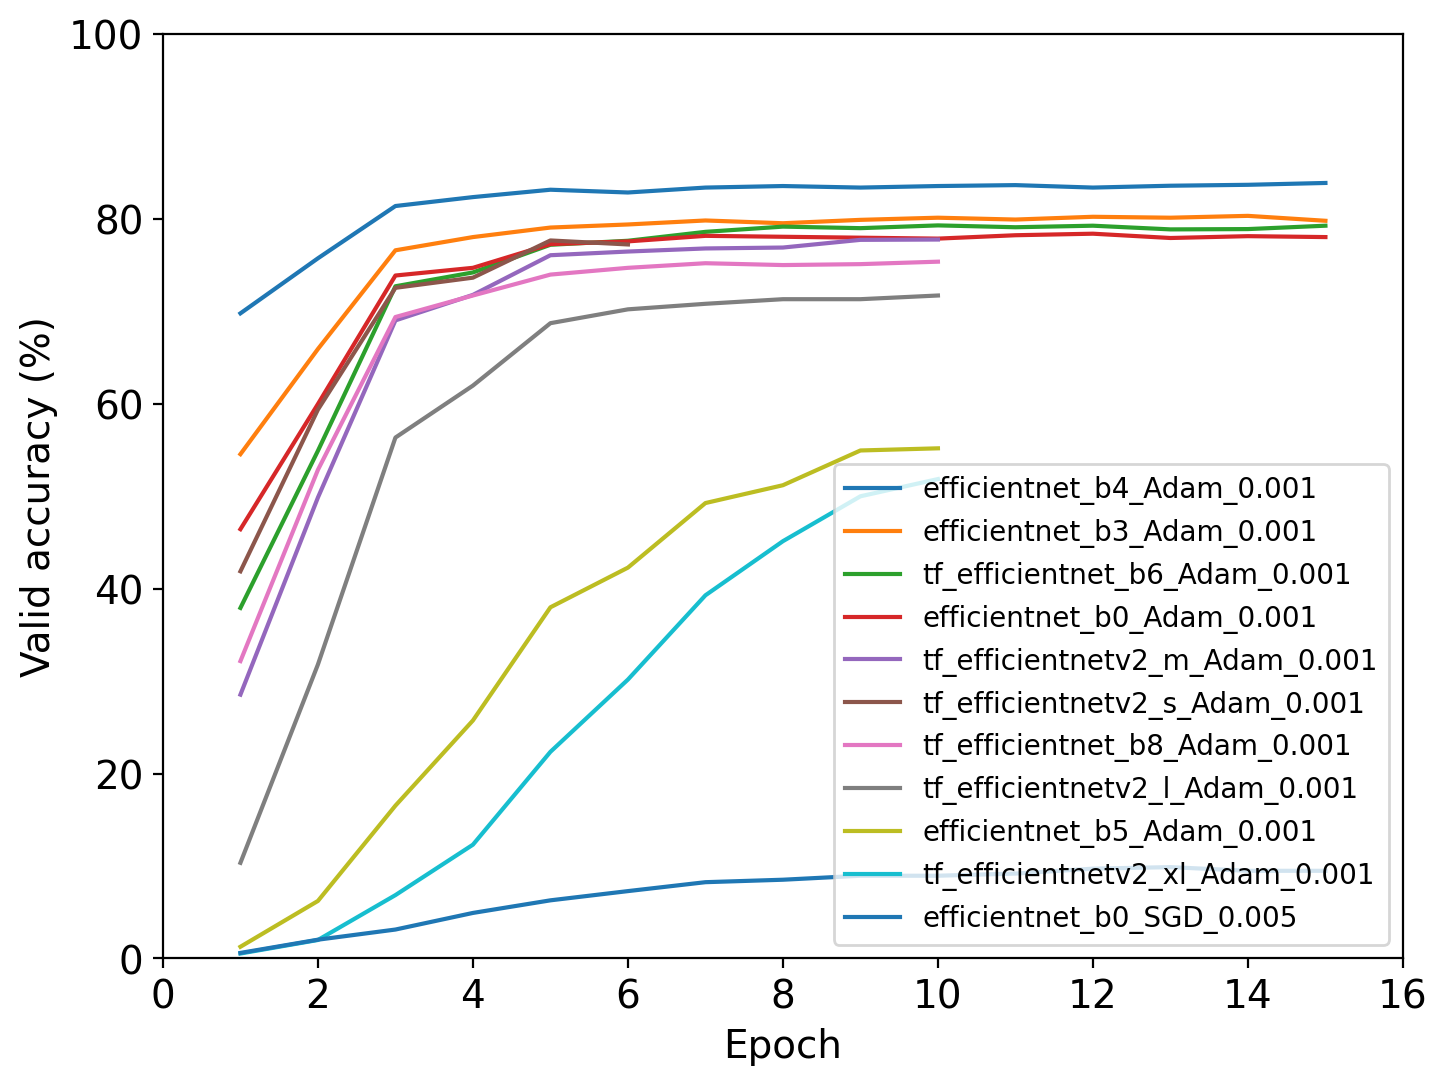

In [59]:
%config InlineBackend.figure_format='retina'
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
sort_result_paths = [result_paths[i] for i in tables.index]

for result_path in sort_result_paths[2:]:
    fold_name = os.path.split(result_path)[-1]
    log_path = os.path.join(result_path, f'{fold_name}_log.csv')
    log = load_log(log_path)

    plt.plot(log['epoch'], log['val_accuracy'] * 100, label = fold_name)

plt.xlabel("Epoch")
plt.ylabel("Valid accuracy (%)")
plt.legend(fontsize = 10)
plt.xlim([0, 16])
plt.ylim([0, 100])